In [36]:
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import modin.pandas as pd
import numpy as np
import shapely
from modin.config import ProgressBar
from tqdm.auto import tqdm

ProgressBar.enable()

In [2]:
tokens = pd.read_parquet("tokens.parquet")

stats = [
    [
        tokens["wforms"].map(len).sum(),
        "total",
    ],
    [
        tokens["wforms_new"].map(len).sum(),
        "prefiltered",
    ],
    [
        (~tokens["wforms"].explode().dropna().duplicated()).sum(),
        "unique",
    ],
    [
        (~tokens["wforms_new"].explode().dropna().duplicated()).sum(),
        "unique prefiltered",
    ],
]

print("Tokens statistics:")
for row in stats:
    print("{: >8} {}".format(*row))

del stats

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-07-25 14:09:03,892	INFO worker.py:1636 -- Started a local Ray instance.


Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 9:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 13:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 17:   0%           Elapsed time: 00:00, estimated remaining time: ?

Tokens statistics:
71458267 total
 6538326 prefiltered
  925843 unique
  745121 unique prefiltered


In [3]:
wforms = pd.read_parquet("wforms-bat.parquet")

stats = [
    [wforms.shape[0], "total"],
    [wforms["fst_batch"].sum(), "1st batch"],
    [wforms["snd_batch"].sum(), "2nd batch"],
    [(wforms["fst_batch"] & wforms["snd_batch"]).sum(), "overlap"],
]

print("Forms statistics:")
for row in stats:
    print("{: >6} {}".format(*row))

del stats

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 7:   0%           Elapsed time: 00:00, estimated remaining time: ?

Forms statistics:
745121 total
  4296 1st batch
  7906 2nd batch
   678 overlap


Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 12:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 20:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 28:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 37:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 43:   0%           Elapsed time: 00:00, estimated remaining time: ?

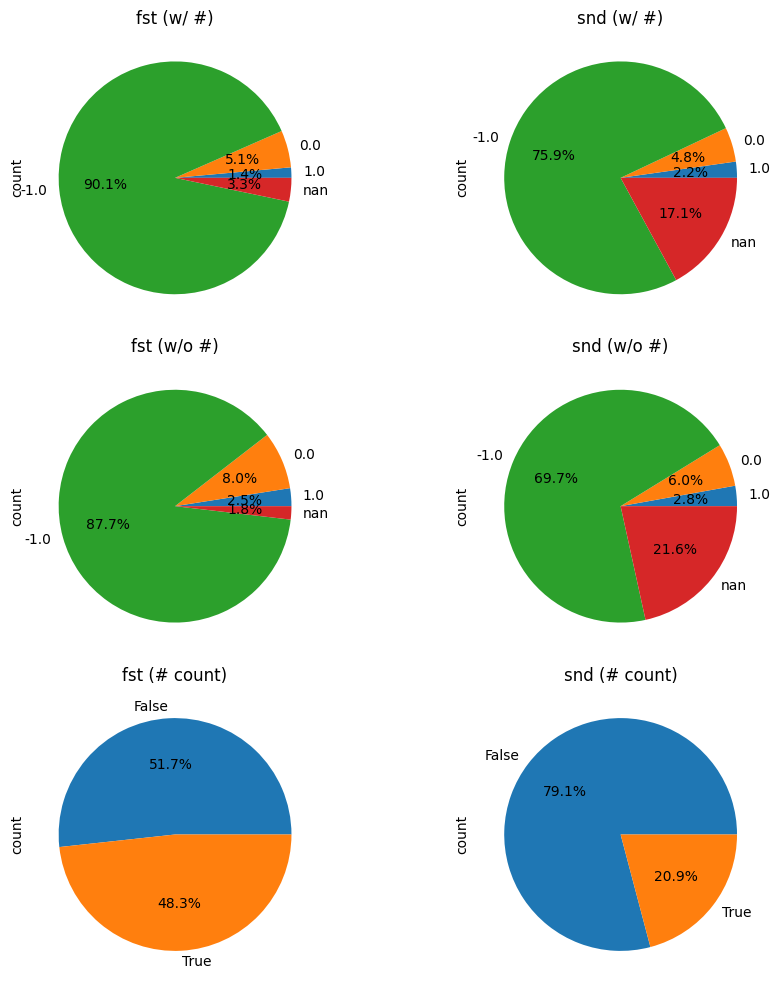

In [56]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

(
    wforms[wforms["fst_batch"]]
    .join(annos, how="left")["status"]
    .value_counts(dropna=False)
    .loc[[+1, 0, -1, np.nan]]
    .plot(kind="pie", autopct="%1.1f%%", ax=ax[0][0], title="fst (w/ #)")
)

(
    wforms[wforms["snd_batch"]]
    .join(annos, how="left")["status"]
    .value_counts(dropna=False)
    .loc[[+1, 0, -1, np.nan]]
    .plot(kind="pie", autopct="%1.1f%%", ax=ax[0][1], title="snd (w/ #)")
)

(
    wforms[wforms["fst_batch"] & ~wforms.index.str.startswith("#")]
    .join(annos, how="left")["status"]
    .value_counts(dropna=False)
    .loc[[+1, 0, -1, np.nan]]
    .plot(kind="pie", autopct="%1.1f%%", ax=ax[1][0], title="fst (w/o #)")
)

(
    wforms[wforms["snd_batch"] & ~wforms.index.str.startswith("#")]
    .join(annos, how="left")["status"]
    .value_counts(dropna=False)
    .loc[[+1, 0, -1, np.nan]]
    .plot(kind="pie", autopct="%1.1f%%", ax=ax[1][1], title="snd (w/o #)")
)

(
    pd.Series(wforms[wforms["fst_batch"]].index.str.startswith("#"))
    .value_counts()
    .plot(kind="pie", autopct="%1.1f%%", ax=ax[2][0], title="fst (# count)")
)

(
    pd.Series(wforms[wforms["snd_batch"]].index.str.startswith("#"))
    .value_counts()
    .plot(kind="pie", autopct="%1.1f%%", ax=ax[2][1], title="snd (# count)")
)

plt.tight_layout()
plt.show()